In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *

from mpi4py import MPI

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F


## Read data

In [2]:
# 1) File path
fname = "./data/h200.f00065"
gname = "./data/h200.f00001"

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
ds = SEMDataset(fname, comm=MPI.COMM_WORLD, gname=gname)
print(ds.fld.fields.keys())


2025-10-28 12:50:55,910 - Mesh - INFO - Initializing empty Mesh object.
2025-10-28 12:50:55,911 - Field - INFO - Initializing empty Field object
2025-10-28 12:50:55,912 - pynekread - INFO - Reading file: ./data/h200.f00001
2025-10-28 12:50:55,937 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-10-28 12:50:55,938 - Mesh - INFO - Initializing common attributes.
2025-10-28 12:50:55,941 - Mesh - INFO - Getting vertices
2025-10-28 12:50:55,941 - Mesh - INFO - Getting edge centers
2025-10-28 12:50:55,944 - Mesh - INFO - Facet centers not available for 2D
2025-10-28 12:50:55,944 - Mesh - INFO - Mesh object initialized.
2025-10-28 12:50:55,944 - Mesh - INFO - Mesh data is of type: float64
2025-10-28 12:50:55,944 - Mesh - INFO - Elapsed time: 0.017350500012980774s
2025-10-28 12:50:55,956 - pynekread - INFO - Reading field data
2025-10-28 12:50:55,992 - pynekread - INFO - File read
2025-10-28 12:50:55,992 - pynekread - INFO - Elapsed time: 0.08161449999897741s
2025-10-28 12:50

In [3]:
# 3) Extract flame front dataframe
scalar_names = [
        "H2","O2","H2O","H","O","OH","HO2","H2O2","N2",
        #Old setup:
        #"heat_release","curvature","stretch_Law","disp_speed_rhoW","disp_speed",
        #"abs_flame_prop_vel","flow_vel_normal","flow_vel_tang","stretch_Poinsot_term",
        #"tangential_strain_Law","nst1_normal_strain","heat_cond_total","heat_cond_normal",
        #"heat_cond_tangential","density_ratio_sigma","vorticity"
]

front = FlameFront2D(ds)

front.make_front_dataframe(
    scalar_name_map=scalar_names,
    sample_mode="progress",
    c_level=0.68,
    tol=0.2,
    include_first_vel_derivs= True,
    include_second_vel_derivs=False,
    include_curvature_derivs=False,
    include_T_derivs=False
)

#Need to have a "chem.yaml" file!
species_list = ["H2", "O2", "H2O", "H", "O", "OH", "HO2", "H2O2", "N2"]
front.add_Le_to_dataset(species_list)
print(front.df.keys())

# 4) Save dataset
front.df.to_csv("flame_front_po_post0.csv", index=False)

2025-10-28 12:50:56,105 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-28 12:50:56,122 - Coef - INFO - done
2025-10-28 12:50:56,122 - Coef - INFO - Elapsed time: 0.01603990001603961s
2025-10-28 12:50:56,125 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-28 12:50:56,139 - Coef - INFO - done
2025-10-28 12:50:56,139 - Coef - INFO - Elapsed time: 0.013158300018403679s
2025-10-28 12:50:56,140 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-28 12:50:56,151 - Coef - INFO - done
2025-10-28 12:50:56,151 - Coef - INFO - Elapsed time: 0.011550199997145683s
2025-10-28 12:50:56,151 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-28 12:50:56,161 - Coef - INFO - done
2025-10-28 12:50:56,162 - Coef - INFO - Elapsed time: 0.009614999988116324s
Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', '

## Field plots

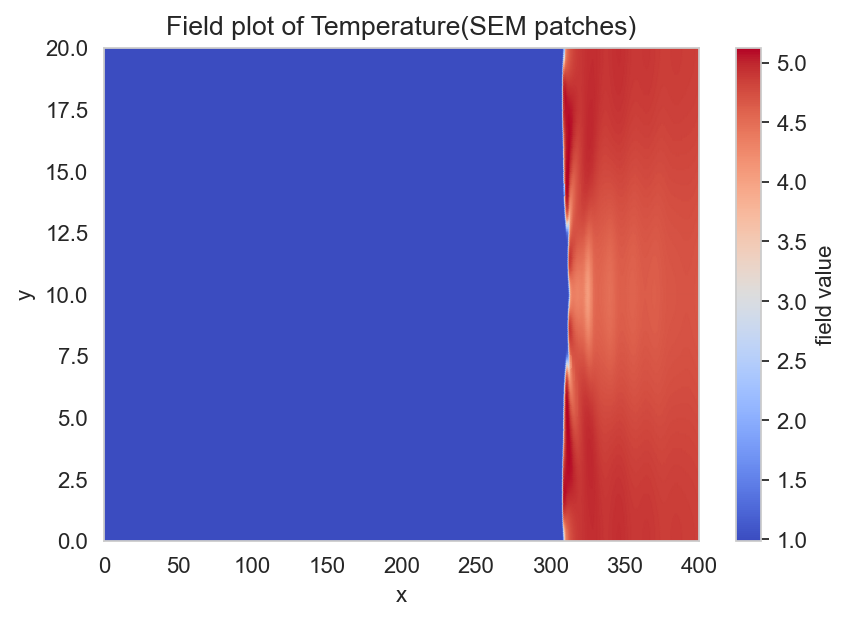

In [4]:
Plot2D.plot_field(ds.msh, ds.T,plot_name="Temperature", mode="sem", cmap="coolwarm")

## Pearson Corellation

In [5]:
Plot2D.print_pearson(front.df, cols=["u","v","T","H2","O2", "Le_def"])

            u    v      T     H2     O2  Le_def
u       1.000 -0.0  0.561 -0.696 -0.396  -0.688
v      -0.000  1.0 -0.000  0.000  0.000   0.000
T       0.561 -0.0  1.000 -0.852 -0.926  -0.697
H2     -0.696  0.0 -0.852  1.000  0.644   0.959
O2     -0.396  0.0 -0.926  0.644  1.000   0.411
Le_def -0.688  0.0 -0.697  0.959  0.411   1.000


## Pairplot

In [6]:
#Plot2D.heat_map(front.df, cols =
#       ["u","v","T","H2","O2", "Le_def"])

cols = ["u","v","T","H2","O2","Le_def"]
sns.pairplot(
    front.df,
    vars=cols,
    hue="c",
    palette="YlOrBr",
    #diag_kind="hist"
    #diag_kws=dict(bins=40, edgecolor=None, alpha=0.8),
);



'\ncols = ["u","v","T","H2","O2","Le_def"]\nsns.pairplot(\n    front.df,\n    vars=cols,\n    hue="c",\n    palette="YlOrBr",\n    #diag_kind="hist"\n    #diag_kws=dict(bins=40, edgecolor=None, alpha=0.8),\n);\n\n'

## NN for velocity prediction

In [7]:
feature_names = ["v","T","H2","O2", "H2O2", "Le_def"]

""""
Old setup:
[ 'curvature' ,'stretch_Law',
        'heat_cond_normal', 'heat_cond_tangential',
        'tangential_strain_Law', 'Le_def', 'vorticity']
"""

ml = MachineLearningModel(features=feature_names, target="u", test_size=0.2, n_epoch= 130)
ml.prepare_data(front.df).build_model().train()
ml.plot_loss()
ml.evaluate()
ml.shap_summary()



'\nml = MachineLearningModel(features=feature_names, target="u", test_size=0.2, n_epoch= 130)\nml.prepare_data(front.df).build_model().train()\nml.plot_loss()\nml.evaluate()\nml.shap_summary()\n'